## Advanced exploratory analysis and machine learning, to predict your personality type
Dataset: https://www.kaggle.com/datasets/datasnaek/mbti-type/data

### Loading data


In [3]:
!unzip archive.zip

Archive:  archive.zip
  inflating: mbti_1.csv              


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv('mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


### Cleaning data

In [7]:
stop = nltk.corpus.stopwords.words('english')
def clean_text(text):
    text = text.replace('|||',' ')
    text = re.sub('https?://\S+|www\.youtube\S+', 'youtube', text)
    text = re.sub('https?://\S+|www\.facebook\S+', 'facebook', text)
    text = re.sub('https?://\S+|www\.instagram\S+', 'instagram', text)
    text = re.sub('https?://\S+|www\.twitter\S+', 'twitter', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split( ) if word not in stop]
    text = " ".join(text)
    text = text.lower()
    return text

In [8]:
df['clean_posts'] = df['posts'].apply(clean_text)

In [9]:
df.head()

,type,posts,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,youtube youtube enfp intj moments youtube spor...
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding lack posts alarming sex boring posi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one youtube of course i say i know thats ...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed conversation day esoteric ...
4,ENTJ,'You're fired.|||That's another silly misconce...,youre fired thats another silly misconception ...


### Exploratory data analysis

##### Number of tweets in each row?

In [10]:
df['num_tweets'] = df['posts'].str.count('\|\|\|') + 1
df['num_tweets'].unique()

array([50, 43, 49, 28, 48, 42, 58, 30, 32, 47, 35, 29, 34, 38, 18, 45, 27,
       12, 23, 59, 53, 56, 36, 46, 44, 21, 63, 33, 10, 66, 37, 14, 39, 25,
       40, 15,  8, 57, 20, 41,  1, 62, 69, 19, 79, 16, 70, 75, 31, 51, 24,
       83,  7, 26, 80, 64, 68, 61, 72, 52, 60, 22,  9, 17, 13, 71, 11,  2,
        4, 67, 54, 78, 77, 89,  5, 73, 74])

##### Number of tweets in each type?

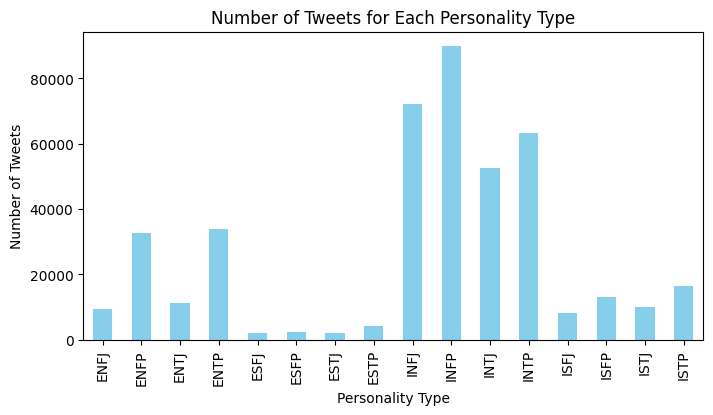

In [11]:
tweets_by_type = df.groupby('type')['num_tweets'].sum()
tweets_by_type.plot(kind='bar', figsize=(8, 4), color='skyblue')
plt.title('Number of Tweets for Each Personality Type')
plt.xlabel('Personality Type')
plt.ylabel('Number of Tweets')
plt.show()

##### Average total word count? (in each post)

In [12]:
df['word_count'] = df['clean_posts'].apply(lambda x: len(x.split()))
df['word_count'].mean()

726.0055331412103

##### Average word count in each type?

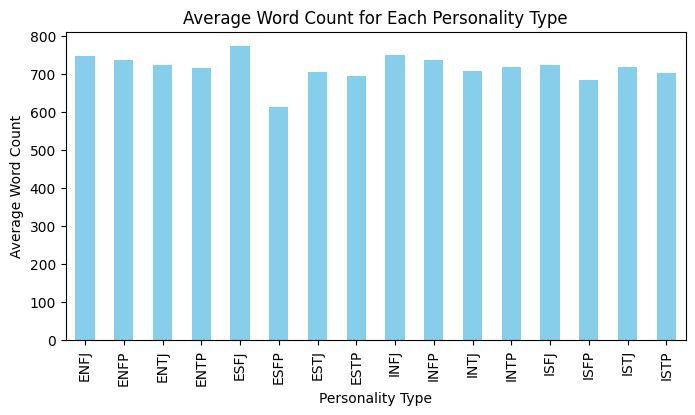

In [13]:
avg_word_count_by_type = df.groupby('type')['word_count'].mean()
avg_word_count_by_type.plot(kind='bar', figsize=(8, 4), color='skyblue')
plt.title('Average Word Count for Each Personality Type')
plt.xlabel('Personality Type')
plt.ylabel('Average Word Count')
plt.show()

##### will the word count have an effect on resuls (accouracy)?
###### *NO*

##### Most used words on all the posts?

In [14]:
vectorizer = CountVectorizer()
word_counts = vectorizer.fit_transform(df['clean_posts'])
feature_names = vectorizer.get_feature_names_out()
total_word_counts = word_counts.sum(axis=0)

# Create a DataFrame to display the most used 10 words
top_words_df = pd.DataFrame({
    'Word': feature_names,
    'Count': total_word_counts.A1  # Convert to a 1D array
})

top_10_words = top_words_df.sort_values(by='Count', ascending=False).head(10)
top_10_words

,Word,Count
57859,im,79093
69712,like,68168
32215,dont,52205
123435,think,49191
91091,people,45923
66615,know,36215
86702,one,35521
100083,really,34835
137575,would,34413
47687,get,30372


##### Which type is most obsessed in talking about others?

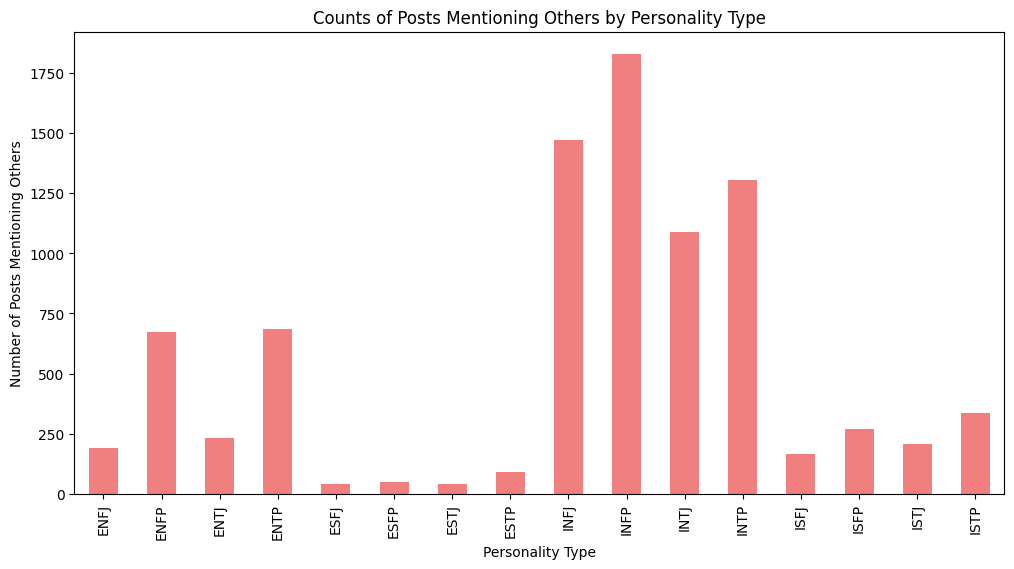

In [15]:
# Define a list of words related to talking about others
words_related_to_others = ['he', 'she', 'they', 'his', 'her', 'their', 'him', 'his', 'hers', 'theirs']

df['mentions_others'] = df['clean_posts'].apply(lambda x: any(word in x for word in words_related_to_others))
mentions_others_by_type = df.groupby('type')['mentions_others'].sum()
most_obsessed_type = mentions_others_by_type.idxmax()
mentions_others_by_type = df.groupby('type')['mentions_others'].sum()

mentions_others_by_type.plot(kind='bar', figsize=(12, 6), color='lightcoral')
plt.title('Counts of Posts Mentioning Others by Personality Type')
plt.xlabel('Personality Type')
plt.ylabel('Number of Posts Mentioning Others')
plt.show()

##### Which type is most obsessed about themselves?

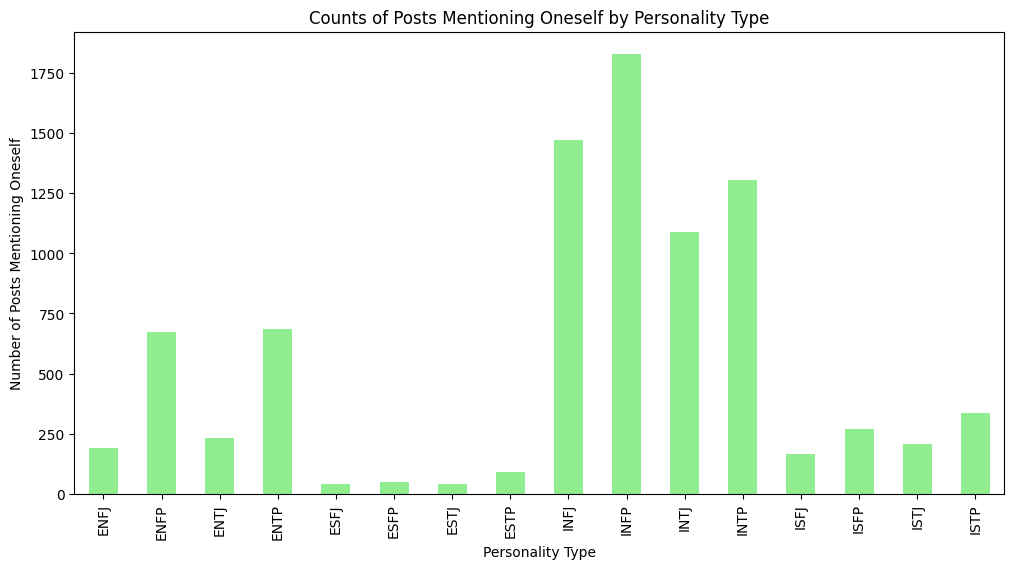

In [16]:
# Define a list of words related to talking about oneself
words_related_to_self = ['i', 'me', 'my', 'mine']

df['mentions_self'] = df['clean_posts'].apply(lambda x: any(word in x for word in words_related_to_self))
mentions_self_by_type = df.groupby('type')['mentions_self'].sum()

mentions_self_by_type.plot(kind='bar', figsize=(12, 6), color='lightgreen')
plt.title('Counts of Posts Mentioning Oneself by Personality Type')
plt.xlabel('Personality Type')
plt.ylabel('Number of Posts Mentioning Oneself')
plt.show()

##### Which type is more romantic?

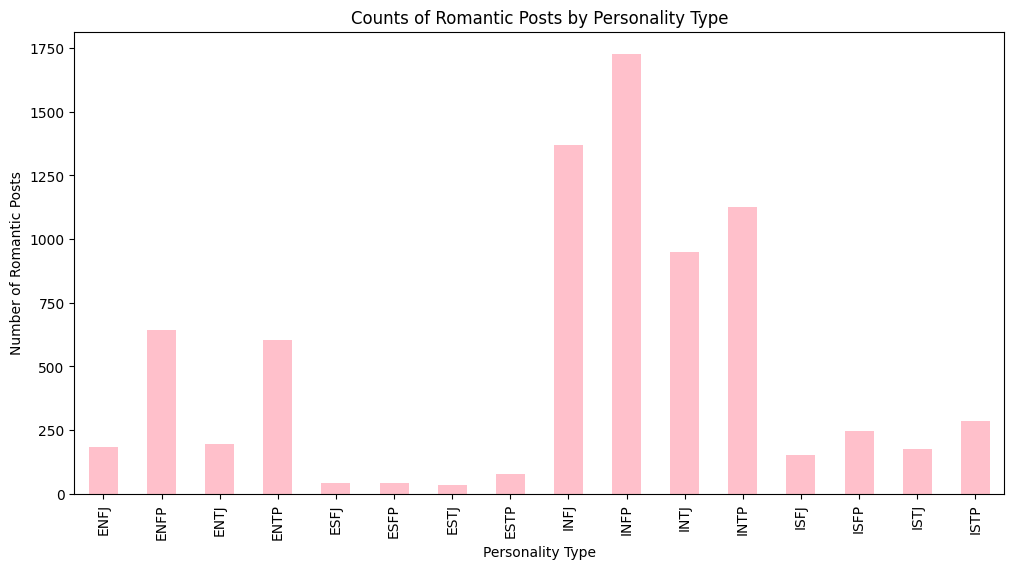

In [17]:
# Define a list of words related to romance
words_related_to_romance = ['love', 'romance', 'date', 'heart', 'sweet', 'kiss', 'cuddle']

df['mentions_romance'] = df['clean_posts'].apply(lambda x: any(word in x for word in words_related_to_romance))
mentions_romance_by_type = df.groupby('type')['mentions_romance'].sum()

mentions_romance_by_type.plot(kind='bar', figsize=(12, 6), color='pink')
plt.title('Counts of Romantic Posts by Personality Type')
plt.xlabel('Personality Type')
plt.ylabel('Number of Romantic Posts')
plt.show()

##### which type is most active on social media?

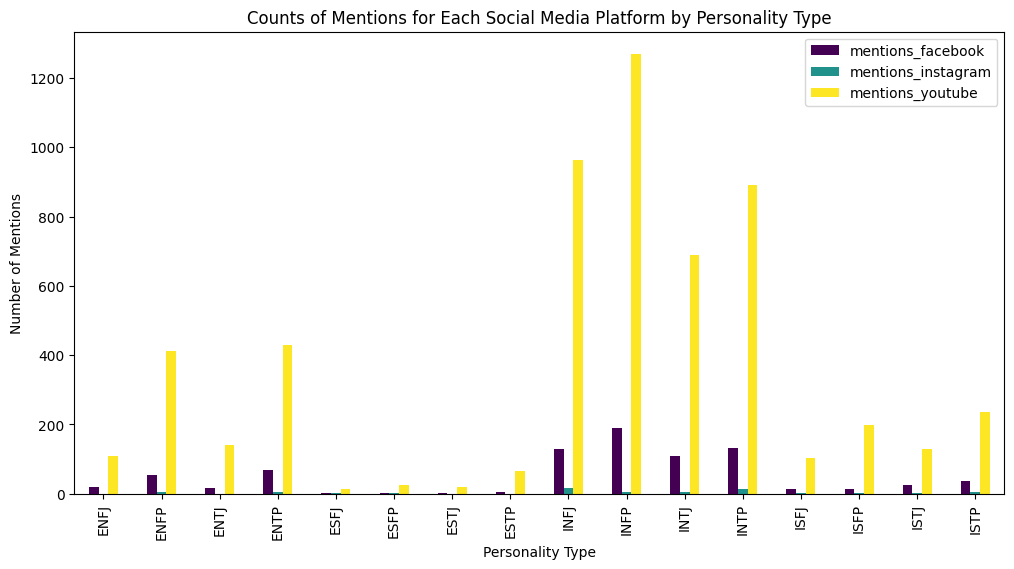

In [18]:
# Define a list of social media platform names
platforms = ['facebook', 'instagram', 'youtube']

# Create columns indicating the presence of platform names in posts
for platform in platforms:
    df[f'mentions_{platform}'] = df['clean_posts'].apply(lambda x: platform in x.lower())
mentions_by_type = df.groupby('type')[[f'mentions_{platform}' for platform in platforms]].sum()

mentions_by_type.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Counts of Mentions for Each Social Media Platform by Personality Type')
plt.xlabel('Personality Type')
plt.ylabel('Number of Mentions')
plt.show()

### Data Pre-processing

splitting data

In [19]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

Vectorizing the clean posts using TfidfVectorizer

In [20]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['clean_posts'])
X_test = vectorizer.transform(test_df['clean_posts'])

creating tragted vriables

In [21]:
y_train = train_df['type']
y_test = test_df['type']

### Modelling and Training

In [22]:
# loading the model
Model = LinearSVC()

In [23]:
# training the model
Model.fit(X_train, y_train)

LinearSVC()

In [24]:
# making predictions
y_pred = Model.predict(X_test)

In [30]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy *100:.2f}")

Accuracy: 66.05


### Real-time predictions

In [26]:
def predict_realtime(comment):
  comment_processed = vectorizer.transform([comment])
  comment_pred = Model.predict(comment_processed)
  return comment_pred[0]

In [27]:
comment = df['clean_posts'].iloc[0]
predict_realtime(comment)

'INFJ'